# Part A 


## DOMAIN: Entertainment


CONTEXT: 


Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. 
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie 
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and 
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the 


 DATA DESCRIPTION:
 
 The dataset comprises of images and its mask for corresponding human face.


 PROJECT OBJECTIVE: To build a face detection system

## Steps and tasks:

## 1. Import and Understand the data

In [1]:
from zipfile import ZipFile
import os;
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2


# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2



# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon


### A. Import and read ‘images.npy’.

In [2]:
data = np.load('images.npy',allow_pickle = True)

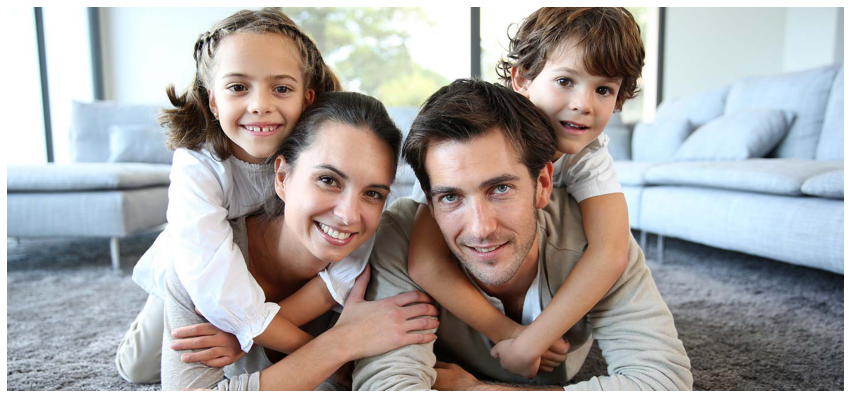

In [3]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[13][0])
plt.show()

In [4]:
print(data[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


### B. Split the data into Features(X) & labels(Y). Unify shape of all the images. 

In [5]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [6]:
Y = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        Y[index][y1:y2, x1:x2] = 1

In [7]:
X.shape

(409, 224, 224, 3)

In [8]:
Y.shape

(409, 224, 224)

### C. Split the data into train and test[400:9]. 


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.02, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((400, 224, 224, 3), (9, 224, 224, 3), (400, 224, 224), (9, 224, 224))

### D. Select random image from the train data and display original image and masked image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


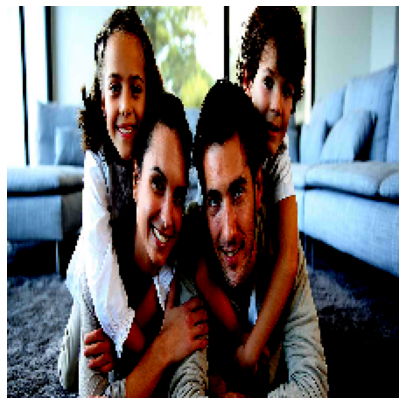

In [10]:
n = 13
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

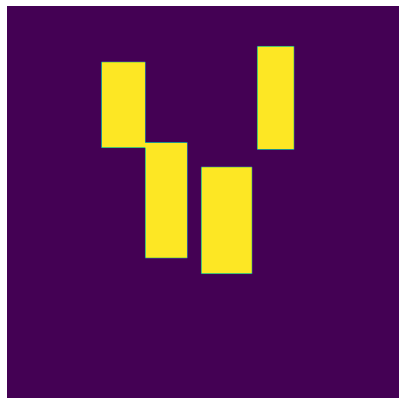

In [11]:
n = 13
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(Y[n])

## 2. Model building

### A. Design a face mask detection model. 
#Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.
#Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture.


In [12]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

In [13]:
model = create_model(True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

### B. Design your own Dice Coefficient and Loss function.

In [14]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [15]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### C. Train and tune the model as require. 


In [16]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

In [17]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

In [18]:
history=model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 1.6171 - dice_coefficient: 0.3693
Epoch 00001: loss improved from inf to 1.61708, saving model to model_1.62.h5
400/400 [==============================] - 724s 2s/step - loss: 1.6171 - dice_coefficient: 0.3693 - val_loss: 1.4252 - val_dice_coefficient: 0.3606 - lr: 1.0000e-04
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 1.1629 - dice_coefficient: 0.4695
Epoch 00002: loss improved from 1.61708 to 1.16293, saving model to model_1.16.h5
400/400 [==============================] - 906s 2s/step - loss: 1.1629 - dice_coefficient: 0.4695 - val_loss: 1.2885 - val_dice_coefficient: 0.3912 - lr: 1.0000e-04
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.9388 - dice_coefficient: 0.5417
Epoch 00003: loss improved from 1.16293 to 0.93881, saving model to model_0.94.h5
400/400 [==============================] - 806s 2s/step - loss: 0.9388 - dice_coefficient: 0.5417 - val_loss: 1.2146

Epoch 25/30
400/400 [==============================] - ETA: 0s - loss: 0.1395 - dice_coefficient: 0.9348
Epoch 00025: loss did not improve from 0.12872
400/400 [==============================] - 790s 2s/step - loss: 0.1395 - dice_coefficient: 0.9348 - val_loss: 0.8531 - val_dice_coefficient: 0.6087 - lr: 1.0000e-04
Epoch 26/30
400/400 [==============================] - ETA: 0s - loss: 0.1282 - dice_coefficient: 0.9398
Epoch 00026: loss improved from 0.12872 to 0.12820, saving model to model_0.13.h5
400/400 [==============================] - 803s 2s/step - loss: 0.1282 - dice_coefficient: 0.9398 - val_loss: 1.1289 - val_dice_coefficient: 0.5788 - lr: 1.0000e-04
Epoch 27/30
400/400 [==============================] - ETA: 0s - loss: 0.1244 - dice_coefficient: 0.9431
Epoch 00027: loss improved from 0.12820 to 0.12444, saving model to model_0.12.h5
400/400 [==============================] - 898s 2s/step - loss: 0.1244 - dice_coefficient: 0.9431 - val_loss: 1.1362 - val_dice_coefficient: 0.5

### D. Evaluate and share insights on performance of the model.


In [19]:
loss, dice_coefficient = model.evaluate(X_valid, y_valid, verbose = 1)
print('Test loss:', loss)
print('Test dice_coefficient:', dice_coefficient)

1/1 [==============================] - 0s 4ms/step - loss: 1.0376 - dice_coefficient: 0.5271
Test loss: 1.0376266241073608
Test dice_coefficient: 0.5271234512329102


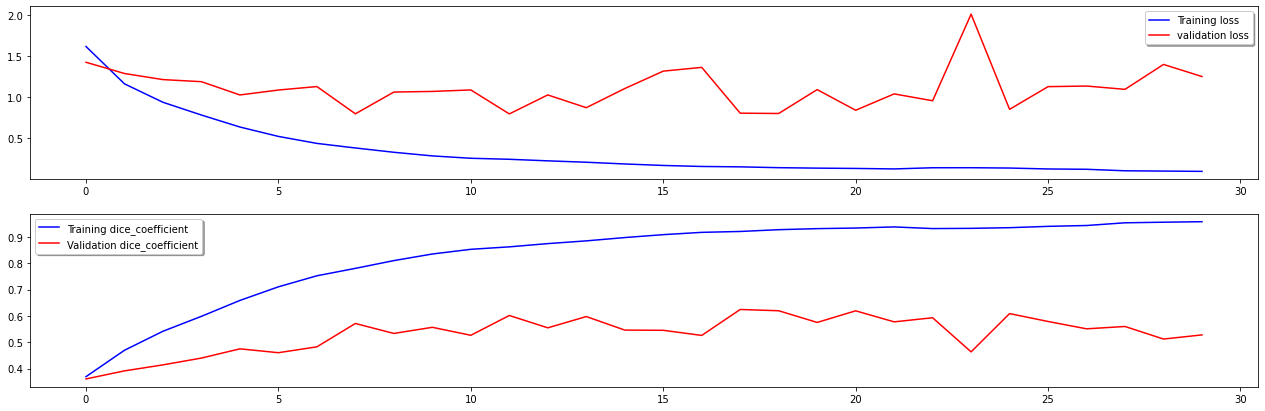

In [20]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['dice_coefficient'], color='b', label="Training dice_coefficient")
ax[1].plot(history.history['val_dice_coefficient'], color='r',label="Validation dice_coefficient")
legend = ax[1].legend(loc='best', shadow=True)

<b> Insights</b>

1. used pretrained MobileNet (Transfer Learning) and on top of it  UNET layers to train
2. Model checkpoint, early stopping and learning rate reducers were used as callbacks.
3. Best training loss: 0.0993 and dice_coefficient: 0.9571
4. at the end of 30th epochs the validation loss and dice coefficeints are 1.3132 , 0.5067 respectively.
5. model performs well in initial epochs and after 10 epochs there is a fluctuation in loss for validation set 

## 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image

In [21]:
# Load previous model weight
WEIGHTS_FILE = "model_0.10.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_valid, verbose = 1)

1/1 [==============================] - 0s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


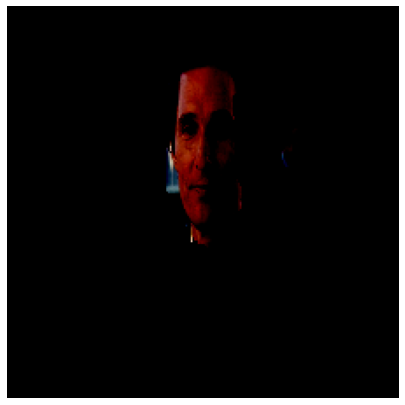

In [22]:
# For a sample image
n = 3
image = cv2.resize(X_valid[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

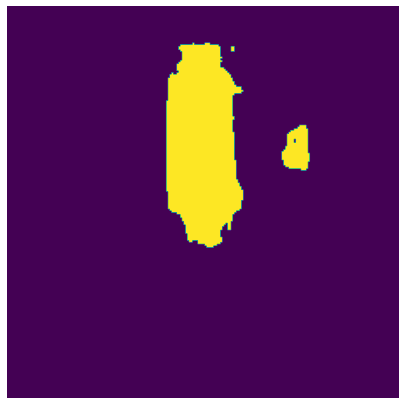

In [23]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


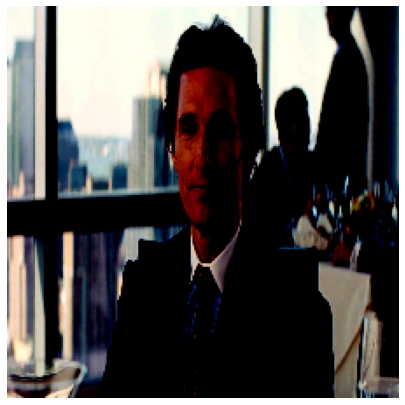

In [24]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

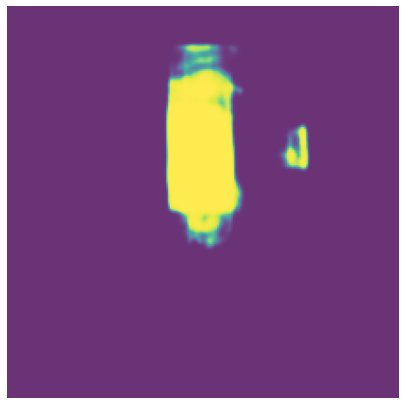

In [26]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

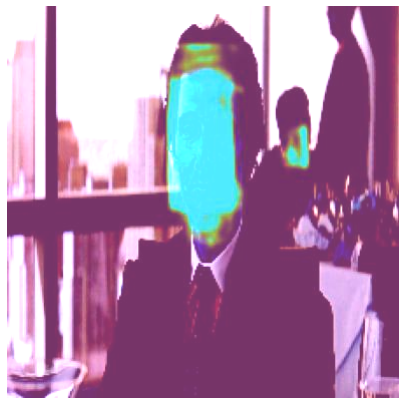

In [27]:
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
#cv2_imshow(img)

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(img)

# Part B

##  DOMAIN: Entertainment

CONTEXT:

Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription 
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on 
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer 
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the 


DATA DESCRIPTION: The dataset comprises of face images.

PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.




## Steps and tasks:

## 1. Read/import images from folder ‘training_images’.





In [28]:
with ZipFile('training_images.zip', 'r') as zip:
    zip.extractall()

In [29]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]



In [30]:
class IdentityMetadata1():
    def __init__(self, base, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 

def load_metadata1(path):
    metadata = []
    exts = []
    for f in os.listdir(path):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata1(path, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata1, exts1 = load_metadata1('training_images')
labels1 = np.array([meta.file for meta in metadata1])

In [31]:
len(metadata1)

1091

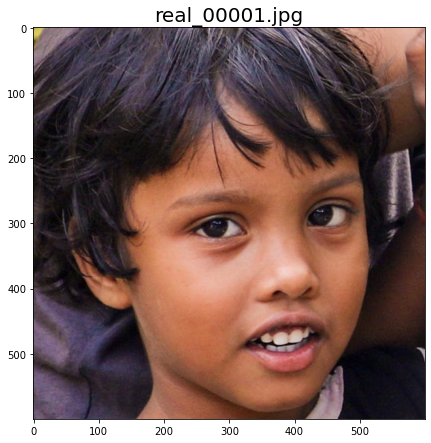

In [32]:
img_path = metadata1[0]
img = load_image(str(img_path))

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels1[0]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

## 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. 

#Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source.


In [33]:
facedetected = []
images=[]
facemeta=[]

for i,meta in tqdm(enumerate(metadata1)):
    image = load_image(str(meta))
    images.append(image) # original image
    
    image = cv2.resize(image, (224, 224),interpolation=cv2.INTER_AREA)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.05,3)
    
    facemeta.append(faces)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(225,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        
    facedetected.append(image)
    
    

0it [00:00, ?it/s]

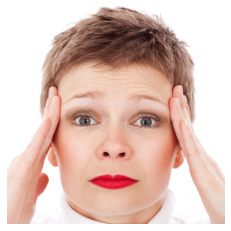

In [34]:
n=1
plt.axis('off')
_ =plt.imshow(images[n])


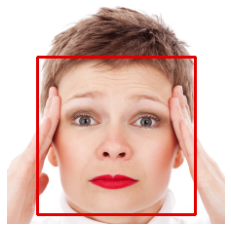

In [35]:
plt.axis('off')
_ =plt.imshow(facedetected[n])

## 3. From the same loop above, extract metadata of the faces and write into a DataFrame.


In [36]:
x_cor=[]
y_cor=[]
wdth=[]
height=[]
nooffaces=[]
image_name=[]
for i,face in tqdm(enumerate(facemeta)):
    if(len(face)>0):     
        for (x,y,w,h) in face:
            x_cor.append(x)
            y_cor.append(y)
            wdth.append(w)
            height.append(h)
            nooffaces.append(len(face))
            image_name.append(labels1[i])
    else:
        x_cor.append(0)
        y_cor.append(0)
        wdth.append(0)
        height.append(0)
        nooffaces.append(len(face))
        image_name.append(labels1[i])

0it [00:00, ?it/s]

In [37]:
output=pd.DataFrame({'x':x_cor,'y':y_cor,'w':wdth,'h':height,'Total_faces':nooffaces,'Image_name':image_name})

In [38]:
output.head()

,x,y,w,h,Total_faces,Image_name
0,56,52,159,159,1,real_00001.jpg
1,31,52,162,162,1,real_00002.jpg
2,14,46,132,132,1,real_00003.jpg
3,50,63,136,136,2,real_00004.jpg
4,4,4,63,63,2,real_00004.jpg


## 4. Save the output Dataframe in .csv format. 

In [39]:
output.to_csv('Facedetection.csv',index=False)

## Part C

## DOMAIN: Face Recognition


CONTEXT: 

Company X intends to build a face identification model to recognise human faces.

DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.


PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken 
from 'Pinterest' and aligned using dlib library. Some data samples:
 



## Steps and tasks:

## 1. Unzip, read and Load data(‘PINS.zip’) into session. 


In [40]:
with ZipFile('PINS.zip', 'r') as zip:
    zip.extractall()

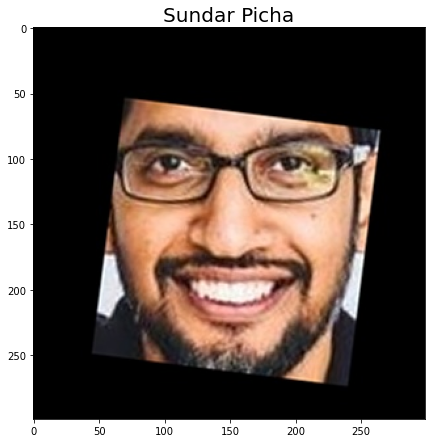

In [41]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

img_path = "PINS\\pins_Sundar Pichai\\Sundar Pichai2_740.jpg"
img = load_image(img_path)

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = 'Sundar Picha'
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

## 2. Write function to create metadata of the image.
Hint: Metadata means derived information from the available data which can be useful for particular problem statement.


In [42]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    


## 3. Write a loop to iterate through each and every image and create metadata for all the images. 


In [43]:
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

## 4. Generate Embeddings vectors on the each face in the dataset. 
Hint: Use ‘vgg_face_weights.h5’


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [45]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     7

In [46]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [47]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [48]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
    try:
        image = load_image(str(meta))
        image = (image/255.).astype(np.float32)
        image = cv2.resize(image, (224, 224))
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
    except:
        embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

## 5. Build distance metrics for identifying the distance between two similar and dissimilar images.


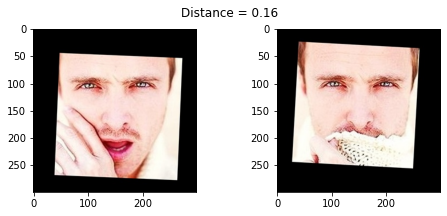

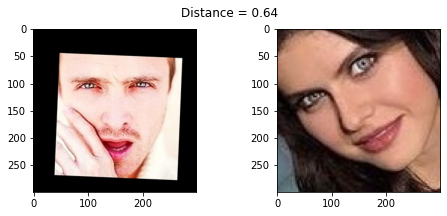

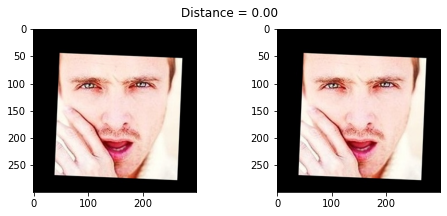

In [49]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

    
show_pair(2, 3)
show_pair(2, 89)
show_pair(2, 2)

In [50]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [51]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [52]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## 6. Use PCA for dimensionality reduction. 


In [53]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416795  18.94867841  22.94242516 ...  99.99999983  99.99999999
 100.        ]


In [54]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


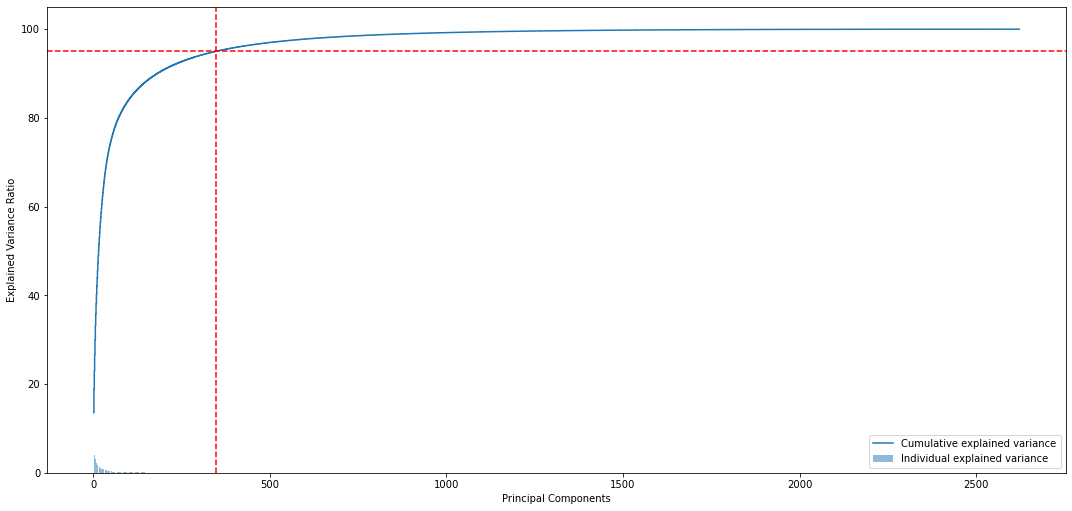

In [55]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [56]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = 12, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

## 7. Build an SVM classifier in order to map each image to its right person.


In [57]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 12)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [58]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.966


In [59]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

## 8. Import and display the the test images.
Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.


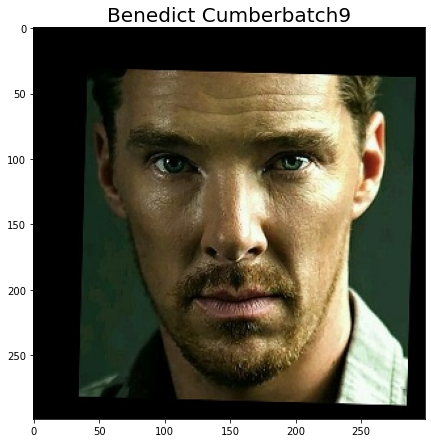

In [60]:
img_path1 = "Benedict Cumberbatch9.jpg"
Test1 = load_image(img_path1)

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = "Benedict Cumberbatch9"
ax.set_title(title, fontsize = 20)
_ = plt.imshow(Test1)

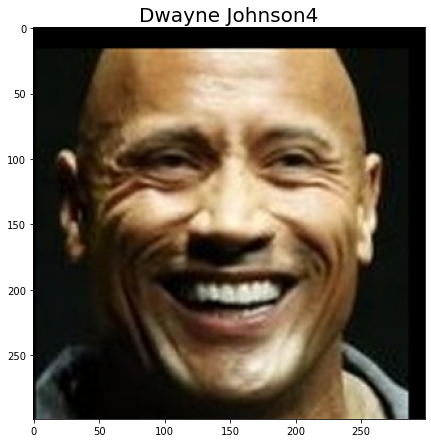

In [61]:
img_path2 = "Dwayne Johnson4.jpg"
Test2 = load_image(img_path2)

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = 'Dwayne Johnson4'
ax.set_title(title, fontsize = 20)
_ = plt.imshow(Test2)

## 9. Use the trained SVM model to predict the face on both test images. 

In [62]:
def sample_img_plot(testimage,actualname):
    # Load image for sample_idx from test data
    sample_img = load_image(testimage)
    # Get actual name
    actual_name = actualname
    # Normalizing pixel values
    sample_img = (sample_img/255.).astype(np.float32)
    # Resize
    sample_img = cv2.resize(sample_img, (224, 224))

    # Obtain embedding vector for sample image
    embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
    # Scaled the vector and reshape
    embedding_scaled = sc.transform(embedding.reshape(1, -1))
    # Predict
    sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
    # Transform back
    pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
    return sample_img, actual_name, pred_name



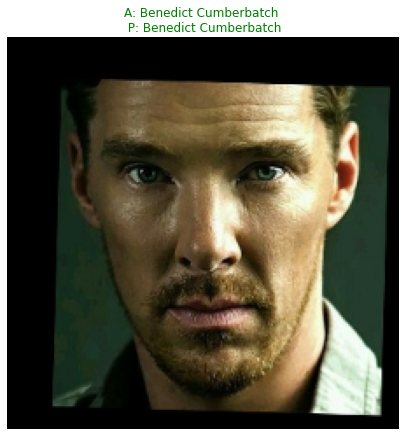

In [63]:
sample_img, actual_name, pred_name = sample_img_plot(img_path1,'Benedict Cumberbatch')
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

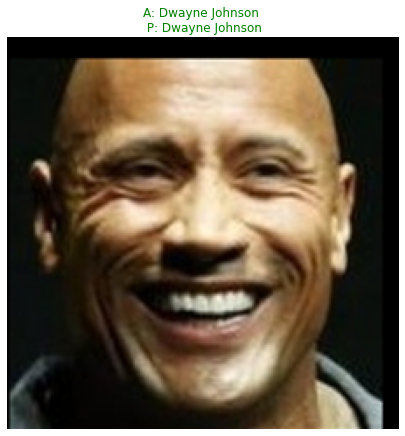

In [64]:
sample_img, actual_name, pred_name = sample_img_plot(img_path2,'Dwayne Johnson')
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()